In [1]:
import pandas as pd
import os
import numpy as np
import epiweeks
import datetime
import requests
import zipfile
import csv
from contextlib import ExitStack
import progressbar as pbar
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json
import warnings
from itertools import product
warnings.filterwarnings('ignore')

In [2]:
# [
#         'Austria',
#         # 'Belgium',
#         # 'Bulgaria',
#         # 'Croatia',
#         # 'Czechia',
#         'Denmark',
#         # 'Estonia',
#         'Finland',
#         'France',
#         'Germany',
#         'Greece',
#         'Hungary',
#         # 'Ireland',
#         'Italy',
#         # 'Latvia',
#         # 'Montenegro',
#         'Netherlands',
#         'Norway',
#         'Portugal',
#         # 'Romania',
#         # 'Slovakia',
#         'Spain',
#         # 'Sweden', not working
#         'Switzerland',
#         # 'Turkey',
#         # 'United Kingdom',
#     ]

In [3]:
def prepare_weekly_covid_deaths(region: str):
    daily_regional_deaths = deaths[deaths['location_name'] == region].reset_index(drop=True)
    daily_regional_deaths = daily_regional_deaths.pivot(values='value', columns='date', index='Age group').fillna(0)
    daily_regional_deaths[daily_regional_deaths < 0] = 0

    weekly_regional_deaths = daily_regional_deaths.copy()
    [str(c) for c in daily_regional_deaths.columns]
    weekly_regional_deaths.columns = [epiweeks.Week.fromdate(datetime.date(year=int(str(c)[:4]), month=int(str(c)[5:7]), day=int(str(c)[8:10]))).isoformat() for c in daily_regional_deaths.columns]           
    t = weekly_regional_deaths.transpose()
    
    weekly_regional_deaths = t.groupby(t.index).sum().transpose()
    return daily_regional_deaths, weekly_regional_deaths

In [4]:
def prepare_weekly_covid_cases(region: str):
    daily_regional_cases = cases[cases['location_name'] == region].reset_index(drop=True)
    daily_regional_cases = daily_regional_cases.pivot(values='value', index='Age group', columns='date').fillna(0)
    daily_regional_cases[daily_regional_cases < 0] = 0

    weekly_regional_cases = daily_regional_cases.copy()
    weekly_regional_cases.columns = [epiweeks.Week.fromdate(datetime.date(year=int(str(c)[:4]), month=int(str(c)[5:7]), day=int(str(c)[8: 10]))).isoformat() for c in daily_regional_cases.columns]
    t = weekly_regional_cases.transpose()
    weekly_regional_covid_cases = t.groupby(t.index).sum().transpose()
    return weekly_regional_covid_cases

In [5]:
def calculate_correction_due_to_aging(region: str):
    correction_due_to_aging = {}
    for year in prior_populations.keys():
        x = population.copy()
        x.iloc[:, 1:] = (prior_populations[year].iloc[:, 1:] / population.iloc[:, 1:])
        correction_due_to_aging[year] = {age_group: float(x[x['Age group'] == age_group][region]) for age_group in x['Age group'].unique()}
    return correction_due_to_aging

In [6]:
def calculate_reference_max_deaths(region, correction_due_to_aging, total_deaths):
    total_deaths = total_deaths[total_deaths['Year'] > str(2015)]
    max_deaths_correct = total_deaths[np.logical_and(total_deaths['Region'] == region, total_deaths['Year'] < '2020')].drop(columns=['Region']).reset_index(drop=True)
    max_deaths_correct['Multiplier'] = max_deaths_correct[['Year', 'Age group']].apply(lambda x: correction_due_to_aging[int(x[0])][x[1]], axis=1)
    for col in range(1, 52 + 1):
        max_deaths_correct[col] = max_deaths_correct[col] / max_deaths_correct['Multiplier']
    max_deaths_correct = max_deaths_correct.groupby('Age group').apply(max)[max_deaths_correct.columns[2:-2]]
    # max_deaths_correct = max_deaths_correct.groupby('Age group').apply(np.mean)[max_deaths_correct.columns[2:-2]]
    max_deaths_correct.columns = [f'W{i:02d}' for i in range(1, len(max_deaths_correct.columns) + 1)]
    y2020 = max_deaths_correct.add_prefix('2020')
    y2021 = max_deaths_correct.add_prefix('2021')
    y2022 = max_deaths_correct.add_prefix('2022')
    y2020['2020W53'] = np.maximum(max_deaths_correct['W01'], max_deaths_correct['W52'])
    max_deaths_concatenated = pd.concat([y2020, y2021, y2022], axis=1)
    max_deaths_concatenated[weekly_regional_deaths.columns]
    return max_deaths_concatenated

In [7]:
def calculate_overall_covid_deaths(region):
    overall_deaths = total_deaths[np.logical_and(total_deaths['Region'] == region, total_deaths['Year'] >= str(2020))].drop(columns=['Region']).reset_index(drop=True)
    y2020 = overall_deaths[overall_deaths['Year'] == '2020'].reset_index(drop=True)[overall_deaths.columns[1:]]
    y2020.columns = ['Age group'] + [f'2020W{i:02d}' for i in range(1, 53 + 1)]
    y2021 = overall_deaths[overall_deaths['Year'] == '2021'].reset_index(drop=True)[overall_deaths.columns[1:-1]]
    y2021.columns = ['Age group'] + [f'2021W{i:02d}' for i in range(1, 52 + 1)]
    y2022 = overall_deaths[overall_deaths['Year'] == '2021'].reset_index(drop=True)[overall_deaths.columns[1:-1]]
    y2022.columns = ['Age group'] + [f'2022W{i:02d}' for i in range(1, 52 + 1)]
    overall_deaths = pd.concat([y2020[y2020.columns[1:]], y2021[y2021.columns[1:]], y2022[y2022.columns[1:]]], axis=1)
    overall_deaths.index = y2020['Age group']
    overall_deaths = overall_deaths.sort_index()
    return overall_deaths

In [8]:
def plot_weekly_cases():
    fig, axs = plt.subplots(1, 2, figsize=(30,10))
    weekly_regional_cases.T.plot(ax=axs[0])
    weekly_regional_cases.cumsum(axis=1).T.plot(ax=axs[1])
    axs[0].set_title(f'Weekly Covid cases recorded by week in age groups ({country} - {region})')
    axs[0].set_xlabel('week')
    axs[0].set_ylabel('deaths')

    axs[1].set_title(f'Cumulative Covid cases recorded by week in age groups ({country} - {region})')
    axs[1].set_xlabel('week')
    axs[1].set_ylabel('deaths')
    
    axs[0].grid()
    axs[1].grid()

    plt.savefig(f'{result_dir_path}/{country}/{region}/cumulative_covid_cases_reported.png')
    plt.close('all')

In [9]:
def plot_weekly_deaths():
    fig, axs = plt.subplots(1, 2, figsize=(30,10))
    weekly_regional_deaths.T.plot(ax=axs[0])
    weekly_regional_deaths.cumsum(axis=1).T.plot(ax=axs[1])
    axs[0].set_title(f'Weekly Covid deaths recorded by week in age groups ({country} - {region})')
    axs[0].set_xlabel('week')
    axs[0].set_ylabel('deaths')

    axs[1].set_title(f'Cumulative Covid deaths recorded by week in age groups ({country} - {region})')
    axs[1].set_xlabel('week')
    axs[1].set_ylabel('deaths')
    
    axs[0].grid()
    axs[1].grid()

    plt.savefig(f'{result_dir_path}/{country}/{region}/cumulative_covid_deaths_reported.png')
    plt.close('all')

In [10]:
def plot_corrected_covid_deaths():
    if not os.path.exists(f'{result_dir_path}/{country}/{region}/gamma={gamma:.2f}'):
        os.mkdir(f'{result_dir_path}/{country}/{region}/gamma={gamma:.2f}')
    for age_group in max_deaths.index:
        fig, axs = plt.subplots(1, 2, figsize=(30,20))
        
        weekly_regional_deaths.loc[age_group, :].T.plot(ax=axs[0])
        corrected_covid_deaths.loc[age_group, :].T.plot(ax=axs[0])
        additional_deaths_not_attributed_to_covid.loc[age_group, :].T.plot(ax=axs[0])
        axs[0].legend(['covid deaths (reported)', f'corrected covid deaths {gamma:.2f}', 'excess deaths'])
        axs[0].set_title(f'Age groups: {age_group} ({country} - {region})')
        axs[0].set_xlabel('week')
        axs[0].set_ylabel('deaths')
        axs[0].grid()
        
        weekly_regional_deaths.loc[age_group, :].cumsum().T.plot(ax=axs[1])
        corrected_covid_deaths.loc[age_group, :].cumsum().T.plot(ax=axs[1])
        additional_deaths_not_attributed_to_covid.loc[age_group, :].cumsum().T.plot(ax=axs[1])
        axs[1].legend(['covid deaths (reported)', f'corrected covid deaths {gamma:.2f}', 'excess deaths'])
        axs[1].set_title(f'Age groups: {age_group} ({country} - {region})')
        axs[1].set_xlabel('week')
        axs[1].set_ylabel('deaths')
        axs[1].grid()

        plt.savefig(f'{result_dir_path}/{country}/{region}/gamma={gamma:.2f}/{age_group}.png')
        plt.close('all')

In [11]:
def plot_cumulative_deaths():
    if not os.path.exists(f'{result_dir_path}/{country}/{region}/Total deaths with max deaths line'):
        os.mkdir(f'{result_dir_path}/{country}/{region}/Total deaths with max deaths line')

    max_deaths_new = pd.DataFrame(max_deaths.iloc[:-1].sum(), index=max_deaths.columns, columns=['Total']).T

    for age_group in max_deaths.index:
        fig, axs = plt.subplots(figsize=(15, 10))
        
        y2020 = total_deaths[np.logical_and(total_deaths['Year'] == '2020', total_deaths['Age group'] == age_group)].drop(['Year', 'Region', 'Age group'],  axis='columns').iloc[:, :]
        y2020.columns = y2020.columns.map(lambda x: f'2020W{x:02d}')
        y2021 = total_deaths[np.logical_and(total_deaths['Year'] == '2021', total_deaths['Age group'] == age_group)].drop(['Year', 'Region', 'Age group'],  axis='columns').iloc[:, :-1]
        y2021.columns = y2021.columns.map(lambda x: f'2021W{x:02d}')
        y2022 = total_deaths[np.logical_and(total_deaths['Year'] == '2022', total_deaths['Age group'] == age_group)].drop(['Year', 'Region', 'Age group'],  axis='columns').iloc[:, :-1]
        y2022.columns = y2022.columns.map(lambda x: f'2022W{x:02d}')
        total_deaths_line = pd.concat([y2020, y2021, y2022], axis=1)
        
        total_deaths_line.loc[:, weekly_regional_deaths.loc[age_group, :].index].T.plot(ax=axs)
        max_deaths.loc[age_group, weekly_regional_deaths.loc[age_group, :].index].T.plot(ax=axs)
        (max_deaths.loc[age_group, weekly_regional_deaths.loc[age_group, :].index] + weekly_regional_deaths.loc[age_group, :].to_numpy()).T.plot(ax=axs)
        axs.legend(['Overall deaths', 'Max deaths', 'Max deaths + covid deaths (reported)'])
        if age_group == 'TOTAL':
            max_deaths_new.loc[:, weekly_regional_deaths.loc[age_group, :].index].T.plot(ax=axs)
            axs.legend(['Overall deaths', 'Max deaths', 'Max deaths + covid deaths (reported)', 'Max deaths - sum(max)'])
        
        axs.set_title(f'Age groups: {age_group} ({country} - {region})')
        axs.set_xlabel('week')
        axs.set_ylabel('deaths')
        axs.grid()

        plt.savefig(f'{result_dir_path}/{country}/{region}/Total deaths with max deaths line/{age_group}.png')
        plt.close('all')

In [12]:
today = datetime.date.today().strftime("%d-%m-%Y")
today = '18-02-2022'
data_dir_path = f'data/World/{today}'
result_dir_path = f'result/World/{today}'
if not os.path.exists(f'{result_dir_path}'):
    os.mkdir(f'{result_dir_path}')
with open(f'{data_dir_path}/eurostat_countries.json', 'r') as file:
    countries = json.load(file)

In [13]:
format_label = pbar.FormatCustomText('Country: %(country)s Running: %(running)s   ', dict(country='start', running='start'))
widgets = [pbar.ETA(), ' ', pbar.Timer(), ' ', pbar.Percentage(format=' (%(percentage)3d%%) '), '  ', format_label]
bar = pbar.ProgressBar(widgets=widgets, maxval=len(countries))
bar.start()

# Data from Germany
ratios = pd.read_csv('./data/Germany/positive_test_to_death_days_distribution.csv')
ratios.index = ratios['offset']
ratios = ratios['probs']

age_group_translator = {'Y_LT5': '00-04', 'Y5-9': '05-09',
                        'Y10-14': '10-14', 'Y15-19': '15-19',
                        'Y20-24': '20-24', 'Y25-29': '25-29',
                        'Y30-34': '30-34', 'Y35-39': '35-39',
                        'Y40-44': '40-44', 'Y45-49': '45-49',
                        'Y50-54': '50-54', 'Y55-59': '55-59',
                        'Y60-64': '60-64', 'Y65-69': '65-69',
                        'Y70-74': '70-74', 'Y75-79': '75-79',
                        'Y80-84': '80-84', 'Y_GE85': '85+',
                        'Y85-89': '85-89', 'Y_GE90': '90+',}

IFRs = {'00-34': [0.041, 0.019, 0.110],
        '35-59': [0.349, 0.194, 0.743],
        '60-79': [2.913, 1.670, 5.793],
        '80+': [7.800, 3.800, 13.300],
        'TOTAL': [1.296, 0.694, 2.453]}

IFRs = {'O\'Driscoll': {'00-34': [0.009, 0.007, 0.010],
                        '35-59': [0.122, 0.115, 0.128],
                        '60-79': [0.992, 0.942, 1.045],
                        '80+': [7.274, 6.909, 7.656],
                        'TOTAL': [0.756, 0.717, 0.796]},
        'Verity': {'00-34': [0.041, 0.019, 0.110],
                   '35-59': [0.349, 0.194, 0.743],
                   '60-79': [2.913, 1.670, 5.793],
                   '80+': [7.800, 3.800, 13.30],
                   'TOTAL': [1.296, 0.694, 2.453]},
        'Perez-Saez': {'00-34': [0.007, 0.003, 0.013],
                       '35-59': [0.070, 0.047, 0.097],
                       '60-79': [3.892, 2.985, 5.145],
                       '80+': [5.600, 4.300, 7.400],
                       'TOTAL': [1.254, 0.959, 0.661]},
        'Levin': {'00-34': [0.016, 0.014, 0.020],
                  '35-59': [0.226, 0.212, 0.276],
                  '60-79': [2.491, 2.294, 3.266],
                  '80+': [15.61, 12.20, 19.50],
                  'TOTAL': [1.687, 1.407, 2.139]}}

age_group_for_ifr = {'00-54': ['00-04', '05-09', '10-14','15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54'],
                     '55-64': ['55-59', '60-64'],
                     '65-74': ['65-69', '70-74'],
                     '75+': ['75-79', '80-84', '85+'],}


for country_index, (country, regions) in enumerate(countries.items()):
    if country not in [
        # 'Austria',
        # # 'Belgium',
        # # 'Bulgaria',
        # # 'Croatia',
        # # 'Czechia',
        # 'Denmark',
        # # 'Estonia',
        # 'Finland',
        # 'France',
        # 'Germany',
        # 'Greece',
        # 'Hungary',
        # # 'Ireland',
        # 'Italy',
        # # 'Latvia',
        # # 'Montenegro',
        # 'Netherlands',
        # 'Norway',
        # 'Portugal',
        # 'Romania',
        # 'Slovakia',
        # 'Spain',
        # # 'Sweden', not working
        # 'Switzerland',
        # 'Turkey',
        # 'United Kingdom',
        'Poland',
    ]:
        continue
    format_label.update_mapping(country=country)
    bar.update()
    
    # Load cases
    # format_label.update_mapping(running='Loading cases' + ' ' * 30)
    # bar.update()
    # cases = pd.read_csv(f'{data_dir_path}/{country}/covid_cases.csv', index_col=0).reset_index(drop=True)
    
    # Load deaths
    format_label.update_mapping(running='Loading deaths' + ' ' * 30)
    bar.update()
    deaths = pd.read_csv(f'{data_dir_path}/{country}/covid_deaths.csv', index_col=0).reset_index(drop=True)
    

    # Load population
    format_label.update_mapping(running='Loading population' + ' ' * 30)
    bar.update()
    population = pd.read_csv(f'{data_dir_path}/{country}/old_population.csv').replace(age_group_translator)
    population = population[population['Year'] >= 2020].reset_index(drop=True)
    new_df = pd.DataFrame({'Age group': population['Age group'].unique()})
    for i, region in enumerate(population['Region'].unique()):
        new_df.insert(i + 1, region, list(population[np.logical_and(population['Region'] == region, population['Sex'] == 'T')]['Value']), True)
    new_df = new_df[~new_df['Age group'].isin(['UNK', 'Y_GE75', 'Y_GE80'])].sort_values('Age group').reset_index(drop=True)
    population = new_df
    
    population.set_index('Age group', inplace=True)
    for new_age_group, age_groups_to_remove in age_group_for_ifr.items():
        population = population.append(pd.DataFrame(population[population.index.isin(age_groups_to_remove)].sum(), columns=[new_age_group]).T)
        population.drop(age_groups_to_remove, inplace=True)
        population.sort_index(inplace=True)
    population = population.reset_index()
    population.rename(columns = {'index': 'Age group'}, inplace=True)
    
    bar.update()
    
    # Load and prepare total deaths
    format_label.update_mapping(running='Loading total deaths' + ' ' * 30)
    bar.update()
    total_deaths = pd.read_csv(f'{data_dir_path}/{country}/old_deaths.csv')
    total_deaths = total_deaths[total_deaths['Region'] == regions]
    total_deaths = total_deaths[total_deaths['Sex'] == 'T'].reset_index(drop=True)
    total_deaths = total_deaths[total_deaths['Year'].apply(lambda x: x[:4]) >= str(2015)].reset_index(drop=True)
    new_df = pd.DataFrame(columns=['Year', 'Region', 'Age group'] + list(np.arange(1, 54)))
    new_df = new_df.append(total_deaths[total_deaths['Sex'] == 'T'])
    new_df['Year'] = new_df['Year'].apply(lambda x: x[:4])
    new_df = new_df.drop(columns='Sex', axis=1)
    new_df = new_df.drop(columns='Value', axis=1)
    new_df = new_df.drop_duplicates()
    bar.update()
    
    for i in range(len(total_deaths)):
        region = total_deaths.iloc[i]['Region']
        age_group = total_deaths.iloc[i]['Age group']
        year = total_deaths.iloc[i]['Year'][:4]
        week = int(total_deaths.iloc[i]['Year'][6:])
        x = np.logical_and(new_df['Region'] == region, new_df['Year'] == year)
        x = np.logical_and(x, new_df['Year'] >= str(2015))
        x = np.logical_and(x, new_df['Age group'] == age_group)
        new_df.loc[x, week] = total_deaths.iloc[i]['Value']
        bar.update()
    total_deaths = new_df[new_df['Year'] >= str(2015)]
    total_deaths = total_deaths.drop(total_deaths.loc[total_deaths['Age group']=='UNK'].index)
    total_deaths = total_deaths.drop(total_deaths.loc[total_deaths['Age group']=='Y_GE75'].index)
    total_deaths = total_deaths.drop(total_deaths.loc[total_deaths['Age group']=='Y_GE80'].index).fillna(0)
    total_deaths.replace(age_group_translator, inplace=True)
    total_deaths = total_deaths.append(total_deaths[total_deaths['Age group'].isin(['85-89', '90+'])].groupby(['Year', 'Region']).sum().reset_index())
    total_deaths = total_deaths.fillna({'Age group': '85+'})
    total_deaths = total_deaths[~total_deaths['Age group'].isin(['85-89', '90+'])].reset_index(drop=True)
    bar.update()
    
    # Load and prepare prior population
    format_label.update_mapping(running='Loading prior population' + ' ' * 30)
    bar.update()
    old_population = pd.read_csv(f'{data_dir_path}/{country}/old_population.csv')
    old_population = old_population[np.logical_and(old_population['Year'] >= 2015, old_population['Year'] < 2020)].reset_index(drop=True)
    prior_populations = dict()

    for year in range(2015, 2020):
        df = pd.DataFrame(columns=['Age group'] + list(old_population['Region'].unique()))
        df['Age group'] = old_population['Age group'].unique()
        for region in old_population['Region'].unique():
            condition = np.logical_and(old_population['Region'] == region, old_population['Year'] == year)
            condition = np.logical_and(condition, old_population['Sex'] == 'T')
            if len(old_population[condition]['Value']) < len(df['Age group']):
                df.loc[:, region] = 0
            else:
                df.loc[:, region] = list(old_population[condition]['Value'])
            bar.update()
        df = df.drop(df.loc[df['Age group']=='UNK'].index)
        df = df.drop(df.loc[df['Age group']=='Y_GE75'].index)
        df = df.drop(df.loc[df['Age group']=='Y_GE80'].index)
        df['Age group'].replace(age_group_translator, inplace=True)
        prior_populations[year] = df.sort_values(by='Age group').reset_index().drop('index', axis=1)
    for year, prior_population in prior_populations.items():
        prior_populations
        prior_population.set_index('Age group', inplace=True)
        
        for new_age_group, age_groups_to_remove in age_group_for_ifr.items():
            prior_population = prior_population.append(pd.DataFrame(prior_population[prior_population.index.isin(age_groups_to_remove)].sum(), columns=[new_age_group]).T)
            prior_population.drop(age_groups_to_remove, inplace=True)
            prior_population.sort_index(inplace=True)
        prior_population = prior_population.reset_index()
        prior_population.rename(columns = {'index': 'Age group'}, inplace=True)
        prior_populations[year] = prior_population
    bar.update()
    
    # Prepare regions set
    # cases_regions_set = set(cases['location_name'].unique())
    deaths_regions_set = set(deaths['location_name'].unique())
    population_regions_set = set(population.columns)
    total_deaths_regions_set = set(total_deaths['Region'].unique())
    prior_populations_regions_set = set(prior_populations[2015].columns)
    # regions_set = cases_regions_set
    regions_set = deaths_regions_set
    regions_set = regions_set.intersection(population_regions_set)
    regions_set = regions_set.intersection(total_deaths_regions_set)
    regions_set = regions_set.intersection(prior_populations_regions_set)
    df = pd.DataFrame(columns= ['Year', 'Region', 'Age group'] + list(range(1, 53+1)))
    
    for region in regions_set:
        for year in total_deaths['Year'].unique():
            new_df = total_deaths[np.logical_and(total_deaths['Region'] == region, total_deaths['Year'] == year)].iloc[:, 2:].set_index('Age group')
            for new_age_group, age_groups_to_remove in age_group_for_ifr.items():
                new_df = new_df.append(pd.DataFrame(new_df[new_df.index.isin(age_groups_to_remove)].sum(), columns=[new_age_group]).T)
                for x in age_groups_to_remove:
                    if x in list(new_df.index):
                        new_df.drop(x, inplace=True)
                new_df.sort_index(inplace=True)
            new_df = new_df.reset_index().rename(columns = {'index': 'Age group'})
            df = df.append(new_df)
            df['Year'] = df['Year'].fillna(year)
            df['Region'] = df['Region'].fillna(region)
    total_deaths = df
    
    for region in regions_set:
        # Prepare dir
        format_label.update_mapping(running='Prepare dir' + ' ' * 30)
        bar.update()
        if not os.path.exists(f'{result_dir_path}/{country}'):
            os.mkdir(f'{result_dir_path}/{country}')
        region = region.replace('*', '')
        if not os.path.exists(f'{result_dir_path}/{country}/{region}'):
            os.mkdir(f'{result_dir_path}/{country}/{region}')  
            
        # Simulation
        format_label.update_mapping(running='Simulation' + ' ' * 30)
        bar.update()
        daily_regional_deaths, weekly_regional_deaths = prepare_weekly_covid_deaths(region)
        # weekly_regional_cases = prepare_weekly_covid_cases(region)
        # weekly_regional_cases = weekly_regional_cases.append(pd.DataFrame(weekly_regional_cases.sum(axis=0), columns=['TOTAL']).T)
        weekly_regional_deaths = weekly_regional_deaths.append(pd.DataFrame(weekly_regional_deaths.sum(axis=0), columns=['TOTAL']).T)
        correction_due_to_aging = calculate_correction_due_to_aging(region)
        max_deaths = calculate_reference_max_deaths(region, correction_due_to_aging, total_deaths)
        overall_deaths = calculate_overall_covid_deaths(region).apply(pd.to_numeric)
        
        # for new_age_group, age_groups_to_remove in age_group_for_ifr.items():
        #     weekly_regional_deaths = weekly_regional_deaths.append(pd.DataFrame(weekly_regional_deaths[weekly_regional_deaths.index.isin(age_groups_to_remove)].sum(), columns=[new_age_group]).T).drop(age_groups_to_remove)
        # weekly_regional_deaths.sort_index(inplace=True)

        # for new_age_group, age_groups_to_remove in age_group_for_ifr.items():
        #     weekly_regional_cases = weekly_regional_cases.append(pd.DataFrame(weekly_regional_cases[weekly_regional_cases.index.isin(age_groups_to_remove)].sum(), columns=[new_age_group]).T).drop(age_groups_to_remove)
        # weekly_regional_cases.sort_index(inplace=True)
        
        overall_minus_max = np.maximum(0, overall_deaths - max_deaths).loc[:, :weekly_regional_deaths.columns[-1]]
        additional_deaths_not_attributed_to_covid = np.maximum(0, overall_minus_max[weekly_regional_deaths.columns] - weekly_regional_deaths).fillna(0)
        
        # Plot results
        format_label.update_mapping(country=country, running='Ploting result: weekly covid deaths' + ' ' * 30)
        bar.update()
        plot_weekly_deaths()
        
        # format_label.update_mapping(country=country, running='Ploting result: weekly covid cases' + ' ' * 30)
        # bar.update()
        # plot_weekly_cases()
        
        format_label.update_mapping(country=country, running='Ploting result: cumulative covid deaths' + ' ' * 30)
        bar.update()
        plot_cumulative_deaths()
        format_label.update_mapping(country=country, running='Ploting result: darkfigure' + ' ' * 30)
        bar.update()
        
        window_list = [1, 3, 5]
        gamma_list = [0.0, 0.2, 0.8, 1.0]

        for gamma, window in product(gamma_list, window_list):
            format_label.update_mapping(country=country, running=f'Ploting result: darkfigure {gamma=}, {window=}' + ' ' * 30)
            bar.update()
            
            
            age_group = '00-54'
            fig, ax = plt.subplots(3, 2, figsize=(30,20))

            weekly_regional_deaths_window = weekly_regional_deaths.rolling(window=window, axis=1, min_periods=1, center=True).mean()
            overall_minus_max_window = np.maximum(0, overall_deaths.rolling(window=window, axis=1, min_periods=1, center=True).mean() - max_deaths.rolling(window=window, axis=1, min_periods=1, center=True).mean()).loc[:, :weekly_regional_deaths.columns[-1]]
            additional_deaths_not_attributed_to_covid_window = np.maximum(0, overall_minus_max_window - weekly_regional_deaths_window).fillna(0)
            corrected_covid_deaths_window = additional_deaths_not_attributed_to_covid_window * gamma + weekly_regional_deaths_window

            overall_minus_max = np.maximum(0, overall_deaths - max_deaths).loc[:, weekly_regional_deaths.columns]
            additional_deaths_not_attributed_to_covid = np.maximum(0, overall_minus_max - weekly_regional_deaths).fillna(0)
            corrected_covid_deaths = additional_deaths_not_attributed_to_covid * gamma + weekly_regional_deaths

            additional_deaths_not_attributed_to_covid_window.loc[age_group].T.plot(ax=ax[0, 0], label=f'excess {gamma=:.2f}', style='b')
            additional_deaths_not_attributed_to_covid.loc[age_group].T.plot(ax=ax[0, 1], label=f'excess {gamma=:.2f}', style='b')


            weekly_regional_deaths_window.loc[age_group].T.plot(ax=ax[1, 0], style='g', label='covid')
            corrected_covid_deaths_window.loc[age_group].T.plot(ax=ax[1, 0], label=f'covid + excess {gamma=:.2f}', style='b')

            weekly_regional_deaths.loc[age_group].T.plot(ax=ax[1, 1], style='g', label='covid')
            corrected_covid_deaths.loc[age_group].T.plot(ax=ax[1, 1], label=f'covid + excess {gamma=:.2f}', style='b')

            weekly_regional_deaths_window.cumsum(axis=1).loc[age_group].T.plot(ax=ax[2, 0], label=f'covid', style='g')
            corrected_covid_deaths_window.cumsum(axis=1).loc[age_group].T.plot(ax=ax[2, 0], label=f'covid + excess {gamma=:.2f}', style='b')
            corrected_covid_deaths.cumsum(axis=1).loc[age_group].T.plot(ax=ax[2, 0], label=f'covid + excess (without mean) {gamma=:.2f}', style='--r')

            weekly_regional_deaths.cumsum(axis=1).loc[age_group].T.plot(ax=ax[2, 1], label='covid', style='g')
            corrected_covid_deaths.cumsum(axis=1).loc[age_group].T.plot(ax=ax[2, 1], label=f'covid + excess {gamma=:.2f}', style='b')

            ax[0, 1].legend()
            ax[0, 0].legend()
            ax[1, 1].legend()
            ax[1, 0].legend()
            ax[2, 1].legend()
            ax[2, 0].legend()

            # ax[0, 0].set_ylim([0, round(np.max(np.max(overall_minus_max)), -2) * 1.1])
            # ax[0, 1].set_ylim([0, round(np.max(np.max(overall_minus_max)), -2) * 1.1])
            # ax[1, 0].set_ylim([0, round(np.max(np.max(corrected_covid_deaths)), -2) * 1.1])
            # ax[1, 1].set_ylim([0, round(np.max(np.max(corrected_covid_deaths)), -2) * 1.1])
            # ax[2, 0].set_ylim([0, round(np.max(np.max(corrected_covid_deaths.cumsum(axis=1))), -2) * 1.1])
            # ax[2, 1].set_ylim([0, round(np.max(np.max(corrected_covid_deaths.cumsum(axis=1))), -2) * 1.1])

            
            
            ax[0, 0].set_title(f'excess deaths with mean {window=}')
            ax[0, 1].set_title('excess deahts without mean')
            ax[1, 0].set_title(f'covid deaths with mean {window=} (weekly)')
            ax[1, 1].set_title('covid deaths without mean (weekly)')
            ax[2, 0].set_title(f'covid deaths with mean {window=} (cumulative)')
            ax[2, 1].set_title('covid deaths without mean (cumulative)')

            ax[0, 1].grid()
            ax[0, 0].grid()
            ax[1, 1].grid()
            ax[1, 0].grid()
            ax[2, 1].grid()
            ax[2, 0].grid()
            
            ax[0, 0].set_xlabel('week')
            ax[0, 1].set_xlabel('week')
            ax[1, 0].set_xlabel('week')
            ax[1, 1].set_xlabel('week')
            ax[2, 0].set_xlabel('week')
            ax[2, 1].set_xlabel('week')
            
            ax[0, 0].set_ylabel('deaths')
            ax[0, 1].set_ylabel('deaths')
            ax[1, 0].set_ylabel('deaths')
            ax[1, 1].set_ylabel('deaths')
            ax[2, 0].set_ylabel('deaths')
            ax[2, 1].set_ylabel('deaths')
            if not os.path.exists(f'{result_dir_path}/{country}/{region}/Window comparation/'):
                os.mkdir(f'{result_dir_path}/{country}/{region}/Window comparation/')
            plt.savefig(f'{result_dir_path}/{country}/{region}/Window comparation/window={window}_gamma={gamma}.png')
            plt.close('all')
            bar.update()
            
#             for age_group in list(age_group_for_ifr.keys()) + ['TOTAL']:
#                 df_lim = 0.0
#                 fig, ax = plt.subplots(len(IFRs), 2, figsize=(30, len(IFRs)*10))
#                 for i, (ifr_name, ifrs) in enumerate(IFRs.items()):
#                     cases_based_on_ifr = corrected_covid_deaths_window.copy().cumsum(axis=1)
#                     df = weekly_regional_cases.rolling(window=window, axis=1, min_periods=1, center=True).mean().cumsum(axis=1)
#                     cases_based_on_ifr.loc[age_group, :] = cases_based_on_ifr.loc[age_group, :].apply(lambda x: 100*x/ifrs[age_group][0])
#                     df.loc[age_group, :] =  cases_based_on_ifr.loc[age_group, :] / df.loc[age_group, :]
#                     df.loc[age_group, :] = df.loc[age_group, :].fillna(0)
#                     df.loc[age_group, :] = df.loc[age_group, :].apply(lambda x: np.maximum(1.0, x))

#                     cases_based_on_ifr.mul(population.loc[:, ['Age group', region]].set_index('Age group').apply(lambda x: 1/x).iloc[:, 0], axis=0).loc[age_group, :].plot(ax=ax[i, 0], label='based on ifr (gamma= 1.0)')
#                     weekly_regional_cases.mul(population.loc[:, ['Age group', region]].set_index('Age group').apply(lambda x: 1/x).iloc[:, 0], axis=0).loc[age_group, :].cumsum().plot(ax=ax[i, 0], label='reported cases')
#                     ax[i, 0].set_title(f'Covid cases based on {ifr_name} IFR')
#                     ax[i, 0].set_xlabel('week')
#                     ax[i, 0].set_ylabel('cases / population [%]')
#                     ax[i, 0].legend()
#                     df.loc[age_group, :].plot(ax=ax[i, 1])
#                     ax[i, 1].set_title(f'Darkfigure based on {ifr_name} IFR')
#                     ax[i, 1].set_xlabel('week')
#                     ax[i, 1].set_ylabel('darkfigure')
#                     ax[i, 0].grid()
#                     ax[i, 1].grid()
#                     df_lim = np.max([df_lim, np.max(df.loc[age_group, :])])
#                 bar.update()
#                 for i in range(len(IFRs)):
#                     ax[i, 0].set_ylim([0, 0.4])
#                     ax[i, 1].set_ylim([0, np.min([20, df_lim * 1.1])])
#                 if not os.path.exists(f'{result_dir_path}/{country}/{region}/Darkfigure/'):
#                     os.mkdir(f'{result_dir_path}/{country}/{region}/Darkfigure/')
#                 plt.savefig(f'{result_dir_path}/{country}/{region}/Darkfigure/window={window}_age_group={age_group}_gamma={gamma}.png')
#             plt.close('all')
#             bar.update()

        format_label.update_mapping(country=country, running=f'Ploting result: Death factor' + ' ' * 30)
        bar.update()
        
        for window in window_list:
            weekly_regional_deaths_window = weekly_regional_deaths.rolling(window=window, axis=1, min_periods=1, center=True).mean()
            overall_minus_max_window = np.maximum(0, overall_deaths.rolling(window=window, axis=1, min_periods=1, center=True).mean() - max_deaths.rolling(window=window, axis=1, min_periods=1, center=True).mean()).loc[:, :weekly_regional_deaths.columns[-1]]
            additional_deaths_not_attributed_to_covid_window = np.maximum(0, overall_minus_max_window - weekly_regional_deaths_window).fillna(0)


            fig, axs = plt.subplots(1, 2, figsize=(30,10))
            for gamma in gamma_list:
                corrected_covid_deaths_window = additional_deaths_not_attributed_to_covid_window * gamma + weekly_regional_deaths_window
                corrected_covid_deaths_window.iloc[:-1].sum().cumsum().plot(ax=axs[0], label=f'gamma = {gamma}')
                corrected_covid_deaths_window.loc['TOTAL'].cumsum().plot(ax=axs[1], label=f'gamma = {gamma}')

            axs[0].legend()
            axs[0].set_xlabel('week')
            axs[0].set_ylabel('deaths')
            axs[0].legend()
            axs[0].grid()
            axs[0].set_title('Total corrected covid deaths by age group')
            axs[0].set_ylim([0, round(np.max(np.max(corrected_covid_deaths.cumsum(axis=1))), -2) * 1.1])

            axs[1].legend()
            axs[1].set_xlabel('week')
            axs[1].set_ylabel('deaths')
            axs[1].grid()
            axs[1].set_title('Total corrected covid deaths by total')
            axs[1].set_ylim([0, round(np.max(np.max(corrected_covid_deaths.cumsum(axis=1))), -2) * 1.1])
            
            if not os.path.exists(f'{result_dir_path}/{country}/{region}/Death factor/'):
                os.mkdir(f'{result_dir_path}/{country}/{region}/Death factor/')
            plt.savefig(f'{result_dir_path}/{country}/{region}/Death factor/window={window}.png')
            plt.close('all')
            bar.update()
        
        
        
    bar.update(country_index)
bar.finish()
print('Simulation done')

Time:  0:00:20 Elapsed Time: 0:00:20  (100%)   Country: Poland Running: Ploting result: Death factor                                                   


Simulation done


In [14]:
table = pd.DataFrame(columns=['Weekly mean', 'Age group', 'Deaths'])
table = table.append(corrected_covid_deaths_window.cumsum(axis=1).iloc[:, -1].reset_index().rename(columns={'2022W07': 'Deaths'}))
table['Weekly mean'] = table['Weekly mean'].fillna(window)
table

,Weekly mean,Age group,Deaths
0,5,00-54,9056.880394
1,5,55-64,15816.979135
2,5,65-74,51045.892444
3,5,75+,100182.065147
4,5,TOTAL,185297.437892


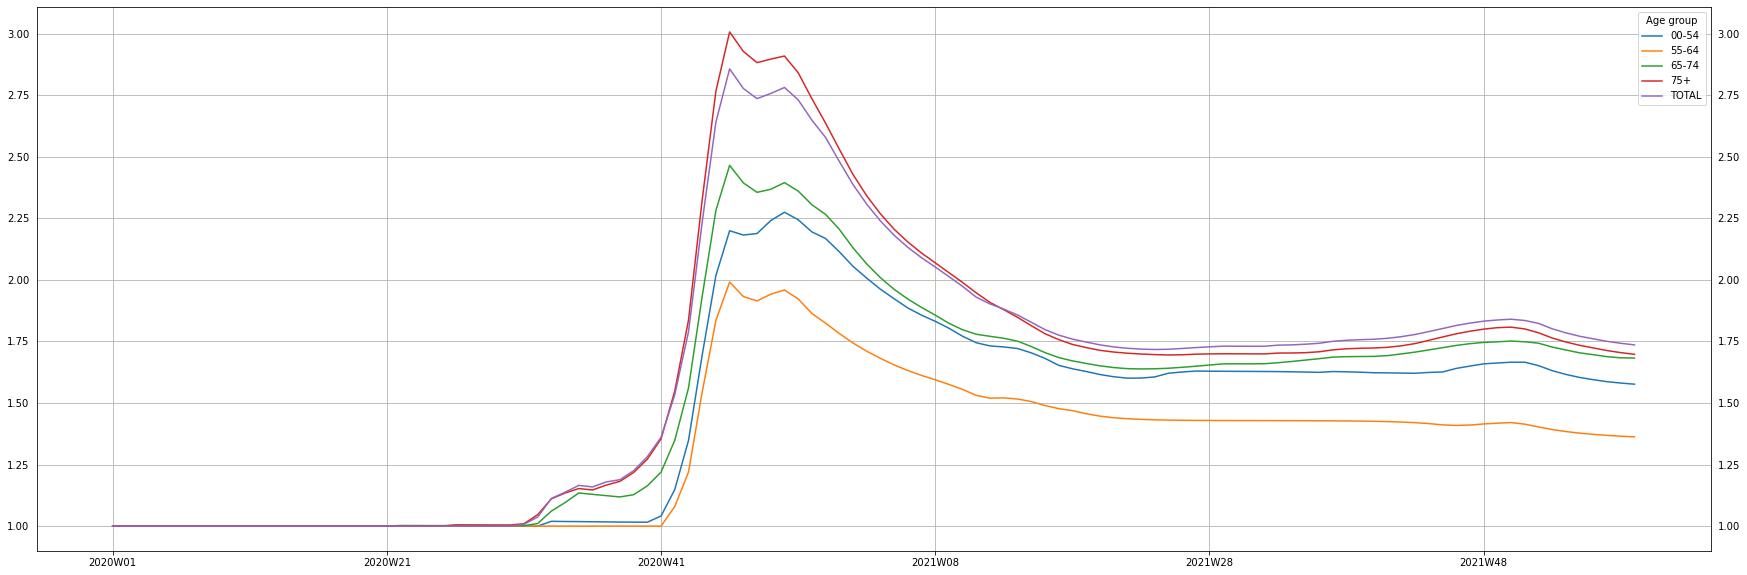

In [15]:
window_list = [3]
fig, axs = plt.subplots(figsize=(30,10))
for window in window_list:
    weekly_regional_deaths_window = weekly_regional_deaths.rolling(window=window, axis=1, min_periods=1, center=True).mean()
    overall_minus_max_window = np.maximum(0, overall_deaths.rolling(window=window, axis=1, min_periods=1, center=True).mean() - max_deaths.rolling(window=window, axis=1, min_periods=1, center=True).mean()).loc[:, :weekly_regional_deaths.columns[-1]]
    additional_deaths_not_attributed_to_covid_window = np.maximum(0, overall_minus_max_window - weekly_regional_deaths_window).fillna(0)
    
    corrected_covid_deaths_window0 = (additional_deaths_not_attributed_to_covid_window * 0.0 + weekly_regional_deaths_window).cumsum(axis=1)
        
    corrected_covid_deaths_window1 = (additional_deaths_not_attributed_to_covid_window * 1.0 + weekly_regional_deaths_window).cumsum(axis=1)
    (corrected_covid_deaths_window1 / corrected_covid_deaths_window0).T.plot(ax=axs)
    axs.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=True,
                     bottom=True, top=False, left=False, right=False)
    axs.grid()
    plt.savefig(f'{result_dir_path}/Poland/PL/excess_covid_deaths_ratio_{window=}.png')
    plt.show()

In [16]:
table = pd.DataFrame(columns=['Weekly mean', 'Gamma', 'Age group', 'Deaths'])

for window in window_list:
    weekly_regional_deaths_window = weekly_regional_deaths.rolling(window=window, axis=1, min_periods=1, center=True).mean()
    overall_minus_max_window = np.maximum(0, overall_deaths.rolling(window=window, axis=1, min_periods=1, center=True).mean() - max_deaths.rolling(window=window, axis=1, min_periods=1, center=True).mean()).loc[:, :weekly_regional_deaths.columns[-1]]
    additional_deaths_not_attributed_to_covid_window = np.maximum(0, overall_minus_max_window - weekly_regional_deaths_window).fillna(0)
    
    
    
    for gamma in gamma_list:
        corrected_covid_deaths_window = additional_deaths_not_attributed_to_covid_window * gamma + weekly_regional_deaths_window
        corrected_covid_deaths_window.iloc[:-1].sum().cumsum().plot(ax=axs[0], label=f'gamma = {gamma}')
        corrected_covid_deaths_window.loc['TOTAL'].cumsum().plot(ax=axs[1], label=f'gamma = {gamma}')
        table = table.append(corrected_covid_deaths_window.cumsum(axis=1).iloc[:, -1].reset_index().rename(columns={'2022W07': 'Deaths'}))
        table['Weekly mean'] = table['Weekly mean'].fillna(window)
        table['Gamma'] = table['Gamma'].fillna(gamma)
table.to_excel(f'{result_dir_path}/Poland/PL/cumulative_deaths.xlsx')

TypeError: 'AxesSubplot' object is not subscriptable

In [ ]:
# window_list = [1, 3, 5, 7]
# gamma_list = [0.0, 0.5, 1.0]

# for gamma, window in product(gamma_list, window_list):    
#     age_group = 'TOTAL'
#     fig, ax = plt.subplots(3, 2, figsize=(30,20))
    
#     weekly_regional_deaths_window = weekly_regional_deaths.rolling(window=window, axis=1, min_periods=1, center=True).mean()
#     overall_minus_max_window = np.maximum(0, overall_deaths.rolling(window=window, axis=1, min_periods=1, center=True).mean() - max_deaths.rolling(window=window, axis=1, min_periods=1, center=True).mean()).loc[:, :weekly_regional_deaths.columns[-1]]
#     additional_deaths_not_attributed_to_covid_window = np.maximum(0, overall_minus_max_window - weekly_regional_deaths_window).fillna(0)
#     corrected_covid_deaths_window = additional_deaths_not_attributed_to_covid_window * gamma + weekly_regional_deaths_window
    
#     overall_minus_max = np.maximum(0, overall_deaths - max_deaths).loc[:, weekly_regional_deaths.columns]
#     additional_deaths_not_attributed_to_covid = np.maximum(0, overall_minus_max - weekly_regional_deaths).fillna(0)
#     corrected_covid_deaths = additional_deaths_not_attributed_to_covid * gamma + weekly_regional_deaths
    
#     additional_deaths_not_attributed_to_covid_window.loc[age_group].T.plot(ax=ax[0, 0], label=f'excess {gamma=:.2f}', style='b')
#     additional_deaths_not_attributed_to_covid.loc[age_group].T.plot(ax=ax[0, 1], label=f'excess {gamma=:.2f}', style='b')

    
#     weekly_regional_deaths_window.loc[age_group].T.plot(ax=ax[1, 0], style='g', label='covid')
#     corrected_covid_deaths_window.loc[age_group].T.plot(ax=ax[1, 0], label=f'covid + excess {gamma=:.2f}', style='b')

#     weekly_regional_deaths.loc[age_group].T.plot(ax=ax[1, 1], style='g', label='covid')
#     corrected_covid_deaths.loc[age_group].T.plot(ax=ax[1, 1], label=f'covid + excess {gamma=:.2f}', style='b')

#     weekly_regional_deaths_window.cumsum(axis=1).loc[age_group].T.plot(ax=ax[2, 0], label=f'covid', style='g')
#     corrected_covid_deaths_window.cumsum(axis=1).loc[age_group].T.plot(ax=ax[2, 0], label=f'covid + excess {gamma=:.2f}', style='b')
#     corrected_covid_deaths.cumsum(axis=1).loc[age_group].T.plot(ax=ax[2, 0], label=f'covid + excess (without mean) {gamma=:.2f}', style='--r')

#     weekly_regional_deaths.cumsum(axis=1).loc[age_group].T.plot(ax=ax[2, 1], label='covid', style='g')
#     corrected_covid_deaths.cumsum(axis=1).loc[age_group].T.plot(ax=ax[2, 1], label=f'covid + excess {gamma=:.2f}', style='b')

#     ax[0, 1].legend()
#     ax[0, 0].legend()
#     ax[1, 1].legend()
#     ax[1, 0].legend()
#     ax[2, 1].legend()
#     ax[2, 0].legend()

#     ax[0, 0].set_ylim([0, round(np.max(np.max(overall_minus_max)), -2) * 1.1])
#     ax[0, 1].set_ylim([0, round(np.max(np.max(overall_minus_max)), -2) * 1.1])
#     ax[1, 0].set_ylim([0, round(np.max(np.max(weekly_regional_deaths)), -2) * 1.1])
#     ax[1, 1].set_ylim([0, round(np.max(np.max(weekly_regional_deaths)), -2) * 1.1])
#     ax[2, 0].set_ylim([0, round(np.max(np.max(corrected_covid_deaths.cumsum(axis=1))), -2) * 1.1])
#     ax[2, 1].set_ylim([0, round(np.max(np.max(corrected_covid_deaths.cumsum(axis=1))), -2) * 1.1])

#     ax[0, 0].set_title(f'excess deaths with mean {window=}')
#     ax[0, 1].set_title('excess deahts without mean')
#     ax[1, 0].set_title(f'covid deaths with mean {window=} (weekly)')
#     ax[1, 1].set_title('covid deaths without mean (weekly)')
#     ax[2, 0].set_title(f'covid deaths with mean {window=} (cumulative)')
#     ax[2, 1].set_title('covid deaths without mean (cumulative)')

#     ax[0, 1].grid()
#     ax[0, 0].grid()
#     ax[1, 1].grid()
#     ax[1, 0].grid()
#     ax[2, 1].grid()
#     ax[2, 0].grid()
#     if not os.path.exists(f'{result_dir_path}/{country}/{region}/Window comparation/'):
#         os.mkdir(f'{result_dir_path}/{country}/{region}/Window comparation/')
#     plt.savefig(f'{result_dir_path}/{country}/{region}/Window comparation/window={window}_gamma={gamma}.png')
#     plt.close('all')
    
#     cases_based_on_ifr = corrected_covid_deaths_window.copy().cumsum(axis=1)
#     df = weekly_regional_cases.rolling(window=window, axis=1, min_periods=1, center=True).mean().cumsum(axis=1)
#     for age_group, ifr in IFRs.items():
#         cases_based_on_ifr.loc[age_group, :] = cases_based_on_ifr.loc[age_group, :].apply(lambda x: 100*x/ifr[0])
#         cases_based_on_ifr
#         df.loc[age_group, :] =  cases_based_on_ifr.loc[age_group, :] / df.loc[age_group, :]
#         df.loc[age_group, :] = df.loc[age_group, :].fillna(0)
#         df.loc[age_group, :] = df.loc[age_group, :].apply(lambda x: np.maximum(1.0, x))

#         fig, ax = plt.subplots(1, 2, figsize=(30,10))
            
#         cases_based_on_ifr.mul(population.loc[:, ['Age group', region]].set_index('Age group').apply(lambda x: 1/x).iloc[:, 0], axis=0).loc[age_group, :].plot(ax=ax[0], label='based on ifr gamma= 1.0')
#         weekly_regional_cases.mul(population.loc[:, ['Age group', region]].set_index('Age group').apply(lambda x: 1/x).iloc[:, 0], axis=0).loc[age_group, :].cumsum().plot(ax=ax[0], label='reported cases')
#         ax[0].set_title(age_group)
#         ax[0].legend()
#         df.loc[age_group, :].plot(ax=ax[1], label='dark figure')
#         ax[1].set_title(age_group)
#         plt.legend()
#         if not os.path.exists(f'{result_dir_path}/{country}/{region}/Darkfigure/'):
#             os.mkdir(f'{result_dir_path}/{country}/{region}/Darkfigure/')
#         plt.savefig(f'{result_dir_path}/{country}/{region}/Darkfigure/window={window}_age_group={age_group}.png')
#     plt.close('all')
    
    
    
# for window in window_list:
#     weekly_regional_deaths_window = weekly_regional_deaths.rolling(window=window, axis=1, min_periods=1, center=True).mean()
#     overall_minus_max_window = np.maximum(0, overall_deaths.rolling(window=window, axis=1, min_periods=1, center=True).mean() - max_deaths.rolling(window=window, axis=1, min_periods=1, center=True).mean()).loc[:, :weekly_regional_deaths.columns[-1]]
#     additional_deaths_not_attributed_to_covid_window = np.maximum(0, overall_minus_max_window - weekly_regional_deaths_window).fillna(0)
    
    
#     fig, axs = plt.subplots(1, 2, figsize=(30,10))
#     for gamma in np.linspace(0, 1, 11):
#         corrected_covid_deaths_window = additional_deaths_not_attributed_to_covid_window * gamma + weekly_regional_deaths_window
#         corrected_covid_deaths_window.iloc[:-1].sum().cumsum().plot(ax=axs[0], label=f'gamma = {gamma}')
#         corrected_covid_deaths_window.loc['TOTAL'].cumsum().plot(ax=axs[1], label=f'gamma = {gamma}')
        
#     axs[0].legend()
#     axs[0].grid()
#     axs[0].set_title('Total corrected covid deaths by age group')
#     axs[0].set_ylim([0, round(np.max(np.max(corrected_covid_deaths.cumsum(axis=1))), -2) * 1.1])

#     axs[1].legend()
#     axs[1].grid()
#     axs[1].set_title('Total corrected covid deaths by total')
#     axs[1].set_ylim([0, round(np.max(np.max(corrected_covid_deaths.cumsum(axis=1))), -2) * 1.1])

#     if not os.path.exists(f'{result_dir_path}/{country}/{region}/Death factor/'):
#         os.mkdir(f'{result_dir_path}/{country}/{region}/Death factor/')
#     plt.savefig(f'{result_dir_path}/{country}/{region}/Death factor/window={window}.png')
#     plt.close('all')